## ----------------------------------
# Artificial nest selection
## ----------------------------------


#### Author: Enrico Gavagnin 
11.08.2022

In this notebook we select the artificial nests for the manipulative experiements (see Section ?? of the Materials and Methods). 

Notation:
* DEH: Degree heterogeneity
* MOD: Modularity
* DIA: Diameter
* CLS: Clustering
* DEN: Density
* MESH: Meshedness

In [2]:
import networkx as nx
import numpy as np
import community
import pandas as pd
import time
import itertools
import pickle 
import sys
import momepy_loc as mm
import statistics as st
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


# Network list
In this section we calculate and save the list of netowrks of the pool of artificial nests ($\mathcal{P}$), see Section ?? of the Materials and Methods. 

In [3]:
# Nest pool name
G6_list_name = '14es'

# All networks are unequily identified using the graph6 format (G6) 
# [ref:http://users.cecs.anu.edu.au/~bdm/data/formats.html]
    # Funciton to convert from G6 to a networx graph
def G6_to_nx(G6):
    n = ord(G6[0]) - 63
    a = np.array([
        int(i) for i in ''.join([f'{ord(c)-63:06b}' for c in G6[1:]])])[:int(n *(n - 1)/2)]
    A = np.zeros((n,n))
    A[np.tril_indices_from(A,-1)]=a
    A = A + A.T 
    G = nx.Graph(A)
    return G

G6_list = []

E_left = [(0,2), (0,3), (0,5), (1,2), (1,3), (2,3), (3,4),
          (3,5), (4,5),  (4,6), (5,6), (5,7),  (6,7)]
E_right = [(0,8),  (0,10),  (0,11), (8,9), (9,10),  (8,10),
           (10,12), (10,11), (11,12), (12,13), (11,13), (11,7), (13,7)]

E_pointer = list(range(13)) 

for r in range(7,14):
    # Generate all link combination for the LHS part of the network with 'r' links
    E_r = list(itertools.combinations(E_pointer,r))
    
    for e_pnt in E_r:
        # Build the network
        e_l = [E_left[i] for i in e_pnt]
        G=nx.Graph(e_l)
        G.add_nodes_from(range(8))
        
        # Check if the network is connected 
        if nx.is_connected(G):
            
            # Add the network to the list
            e_r = [E_right[i] for i in e_pnt]
            G = nx.Graph()
            G.add_nodes_from(range(14))
            G.add_edges_from(e_l+e_r)
            G6_list.append(nx.to_graph6_bytes(G).decode("utf-8")[10:-1])
            
            # Add the network with the additional link (5,11) to the list
            G.add_edge(5,11)
            G6_list.append(nx.to_graph6_bytes(G).decode("utf-8")[10:-1])
            
# Define the nodes xy coordinate (for visual representaiton)
h=-0.8660
coord = np.array([[1.5,h], [0,0], [1,0], [0.5,h], [0,2*h], [1,2*h], [0.5,3*h],
          [1.5,3*h], [2,0], [3,0], [2.5,h], [2,2*h], [3,2*h], [2.5,3*h]])
pos = {n:coord[n] for n in range(14)}

# Save pool list
with open(G6_list_name + "/graph_list.txt", "wb") as fp:   #Pickling    
        pickle.dump(G6_list, fp)



# Properties list

In ths script we calculate the relevan netowrk properties for all the netowrks in $\mathcal{P}$.

In [4]:
import multiprocess as mp
import pickle

In [4]:
def prop_calculator(G6):
        
    G = G6_to_nx(G6)
    
    partition = community.best_partition(G,randomize=False)
    d = {'G6': G6,
         'density': nx.density(G),
         'degree_heterogeneity': st.pvariance([G.degree(n) for n in G.nodes()]),
         'diameter': nx.diameter(G),
         'meshedness': mm.meshedness(G,radius=None),
         'entrance_degree': G.degree(0),
         'entrance_centrality': nx.betweenness_centrality(G)[0],
         'clustering': nx.average_clustering(G),
         'modularity': community.modularity(partition, G)
         }
    return(d)

ABR = {'G6': 'G6',
       'density': 'DEN',
       'degree_heterogeneity': 'DEH',
       'diameter': 'DIA',
       'meshedness': 'MES',
       'entrance_degree': 'EDG',
       'entrance_centrality': 'ECN',
       'clustering': 'CLU',
       'modularity': 'MOD'
       }

In [5]:

def df_P_maker(G6_list_name,df_P_dist_tot,df_P_dist_num):
    
    # Read G6_list data 
    with open(G6_list_name+"/graph_list.txt", "rb") as fp:    
        G6_list = pickle.load(fp)[df_P_dist_num::df_P_dist_tot]

    global dictinary_list
    dictinary_list = []
    
    def append_data(d):
        global dictinary_list
        dictinary_list.append(d)
    
    # Time record start
    start_time = time.time()

    # Start parallel pool
    pool = mp.Pool()
    # Loop over graph list
    for G6 in G6_list:
        pool.apply_async(prop_calculator, (G6,), callback=append_data)
        #append_data(prop_calculator(G6))
    # Close parallel pool
    pool.close()
    pool.join()
    
    # Assemble Dataframe
    df_P = pd.DataFrame.from_dict(dictinary_list).set_index('G6')
    

    # Data save
    df_P.to_csv(G6_list_name +'/df_P_ja/' + 'df_P_%d.csv' % (df_P_dist_num))    

    end_time = time.time()
    print('Execution time P_maker= %.6f seconds' % (end_time - start_time))
    

#%%=============== MAIN SCRIPT =============


df_P_dist_tot = 2

for df_P_dist_num in range(df_P_dist_tot): 
    df_P_maker(G6_list_name,df_P_dist_tot,df_P_dist_num)



Execution time P_maker= 1.426623 seconds
Execution time P_maker= 1.366834 seconds


# Property pairwise comparison dataframe
In this script we list all the pairwise comparison within the pool $\mathcal{P}$ and produce a dataframe containing all the absolute difference in all the properties considered. 

In [5]:
import os
import ast
import dask.dataframe as dd

In [7]:

def df_diff_P_iterable(shift, tresh=None, dgt=4, normalisation='standard'):
    global ddf_P
    # Compute property difference
    df_diff_P_temp = (np.abs((ddf_P.iloc[:-shift, 1:] - ddf_P.iloc[shift:, 1:].reset_index(drop=True)))).astype('int16')
    # Insert index of temporary data frame
    df_diff_P_temp.insert(0,
                     'G6_pair',
                     [ddf_P.G6[i] + '-' + ddf_P.G6[i + shift] for i in range(len(ddf_P) - shift)])
    if tresh!=None:
         df_diff_P_temp = df_diff_P_temp[df_diff_P_temp.min(axis=1)<= tresh * 10**dgt]
    return (df_diff_P_temp)


def df_diff_P_maker(G6_list_name,df_diff_P_dist_tot,df_diff_P_dist_num, dgt=4, normalisation='standard'):
    # Time record start
    start_time = time.time()

    global ddf_P
    ddf_P = dd.read_csv(G6_list_name + '/df_P_ja/df_P_*.csv').set_index('G6')
    ddf_P_min = ddf_P.min().compute()
    ddf_P_max=ddf_P.max().compute()
    if normalisation=='standard':
        ddf_P = (10**dgt * ( (ddf_P - ddf_P_min) / (ddf_P_max-ddf_P_min))).fillna(0).replace([np.inf, -np.inf], 0)
    ddf_P = ddf_P.compute().reset_index()

    # Save ddf_min/max
    pd.DataFrame({'max':ddf_P_max,'min':ddf_P_min}).to_csv(G6_list_name + '/ddf_P_min_max.csv')

    global df_diff_P
    df_diff_P = pd.DataFrame()
    def append_data_df_diff_P(d):
        global df_diff_P
        df_diff_P = df_diff_P.append(d, ignore_index=True)
    # Time record start
    start_time = time.time()
    # Start parallel pool
    pool = mp.Pool()
    # Loop over graph list

    for shift in range(df_diff_P_dist_num, len(ddf_P)+1, df_diff_P_dist_tot):
        pool.apply_async(df_diff_P_iterable, kwds={'shift': shift,'normalisation': normalisation,'tresh':None, 'dgt': 4}, callback=append_data_df_diff_P)
#        append_data_df_diff_P(df_diff_P_iterable(shift, normalisation=normalisation))
    # Close parallel pool
    pool.close()
    pool.join()
    # Data save
    df_diff_P.index += int((df_diff_P_dist_num-1) * np.floor((len(ddf_P))*(len(ddf_P))/(2*df_diff_P_dist_tot)))
    if len(df_diff_P)>0:
        df_diff_P.to_csv(G6_list_name +'/df_diff_P_ja/' + 'df_diff_P_%d.csv' % (df_diff_P_dist_num), index=True)


    end_time = time.time()
    print('Execution time diff_P_maker = %.6f seconds' % (end_time - start_time))
    return()

#%%=============== MAIN SCRIPT  =============

# number of partitioning 
df_diff_P_dist_tot = 20

for df_diff_P_dist_num in range(1, df_diff_P_dist_tot + 1):
    df_diff_P_maker(G6_list_name, df_diff_P_dist_tot,df_diff_P_dist_num)


Execution time diff_P_maker = 4.811369 seconds
Execution time diff_P_maker = 4.765236 seconds
Execution time diff_P_maker = 4.967608 seconds
Execution time diff_P_maker = 4.838787 seconds
Execution time diff_P_maker = 5.063067 seconds
Execution time diff_P_maker = 4.660512 seconds
Execution time diff_P_maker = 4.973401 seconds
Execution time diff_P_maker = 5.846169 seconds
Execution time diff_P_maker = 4.830722 seconds
Execution time diff_P_maker = 5.062492 seconds
Execution time diff_P_maker = 4.589176 seconds
Execution time diff_P_maker = 4.814608 seconds
Execution time diff_P_maker = 4.901596 seconds
Execution time diff_P_maker = 4.789346 seconds
Execution time diff_P_maker = 4.863960 seconds
Execution time diff_P_maker = 5.003815 seconds
Execution time diff_P_maker = 4.845053 seconds
Execution time diff_P_maker = 4.739992 seconds
Execution time diff_P_maker = 5.101155 seconds
Execution time diff_P_maker = 5.121167 seconds


# Optimal Nest Pairs
In this script we perform the artificial nest selection by applying the min-max algorithm (see Section ?? of Material and Methods). We reported the list of optimal paris and we visualise the corresponding diagrams and the properties values in relation to the pool properties' distribution. 

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Function to plot pair of nests diagrams

def plot_pair(name, pair, c, pairs_num=0, save_name=None): 
    
    # Font size
    fs=30
    fig = plt.figure(figsize=[20,7])
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)

    # Read graph6 format of nest pair
    g1 = pair[:int((len(pair)-1)/2)]
    g2 = pair[int((len(pair)-1)/2)+1:]
    h=-0.8660

    # xy coordinate of nodes
    coord = np.array([[1.5,h], [0,0], [1,0], [0.5,h], [0,2*h], [1,2*h], [0.5,3*h],
                      [1.5,3*h], [2,0], [3,0], [2.5,h], [2,2*h], [3,2*h], [2.5,3*h]])
    pos = {n:c for n,c in enumerate(coord)}
    
    # Draw nodes and links of nest diagrams
    color_map = ['r'] + ['k'] * 13
    nx.draw(G6_to_nx(g1), node_color=color_map,with_labels=True, 
            node_size=3000,width=2.5,edge_color='dimgray',font_color='w',
            font_size=fs,ax=ax1, pos=pos)
    nx.draw(G6_to_nx(g2), node_color=color_map,with_labels=True, 
            node_size=3000,width=2.5,edge_color='dimgray',font_color='w',
            font_size=fs,ax=ax2,pos=pos)
    
    # Visual adjustments
    ax1.set_xlim([h/2, -4*h])
    ax1.set_ylim([4*h, -h/2])
    ax2.set_xlim([h/2, -4*h])
    ax2.set_ylim([4*h, -h/2])
    d1 = prop_calculator(g1)
    d2 = prop_calculator(g2)
    plt.rcParams['axes.titlepad'] = -23
    ax1.set_title('Nest A\n', fontsize = 45)
    ax2.set_title('Nest B\n', fontsize = 45)
    ax1.axis('tight')
    ax2.axis('tight')
    
    # Save nest diagram figure
    fig.savefig(G6_list_name + '/plots/top_pair_' + str(cluster), dpi=250)
    
    # Table of value comparison
    
    # Figure settings
    fig = plt.figure(figsize=[11,4])
    ax = plt.subplot(111)
    ax.axis('tight')
    ax.axis('off')
    
    # Load properties dataframe
    Pmm = pd.read_csv(name + '/ddf_P_min_max.csv').set_index('Unnamed: 0')

    # Compute standarized difference of properties values
    diff = [np.abs(d1[key] - d2[key])/(Pmm.loc[key,'max'] -  Pmm.loc[key,'min']) for key in list(d1.keys())[1:]]
    
    # Table design
    columns = ['$\\bf{' + ABR[pr] + '}$'  for pr in list(d1.keys())[1:]]
    rows = ['Nest A \n(Absolute)', 'Nest B\n(Absolute)', 'Difference (A-B)\n(Standarized)']
    cell_text = [['{:.2f}'.format(vl) for vl in list(d1.values())[1:]],
                 ['{:.2f}'.format(vl) for vl in list(d2.values())[1:]],
                 ['{:.2f}'.format(vl) for vl in diff]]
    colors = ['salmon' if (pr in c) else 'lightblue' for pr in list(d1.keys())[1:]]
    colors = [colors, colors, colors]

    # Print table
    T = ax.table(cellText=cell_text,
                  rowLabels=rows,
                  cellLoc='center',
                  cellColours=colors,
                  colLabels=columns,
                  colWidths=[0.07] * 8,
                  loc='center')
    T.scale(1, 2)
    
    # Save table figure
    fig.savefig(G6_list_name + '/plots/table_prop_' + str(cluster), dpi=250)
    
    return [d1,d2]


Execution time Top_pair = 27.477326 seconds
Execution time Top_pair = 25.591114 seconds
Execution time Top_pair = 25.923382 seconds
Execution time Top_pair = 29.554477 seconds


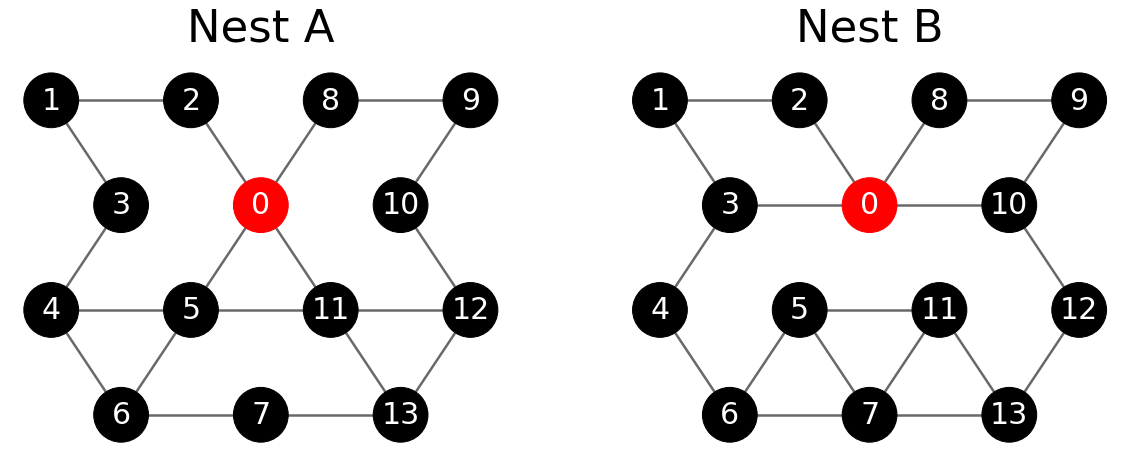

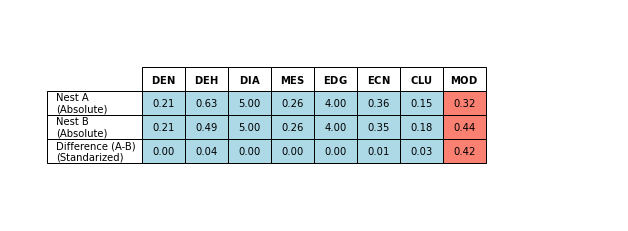

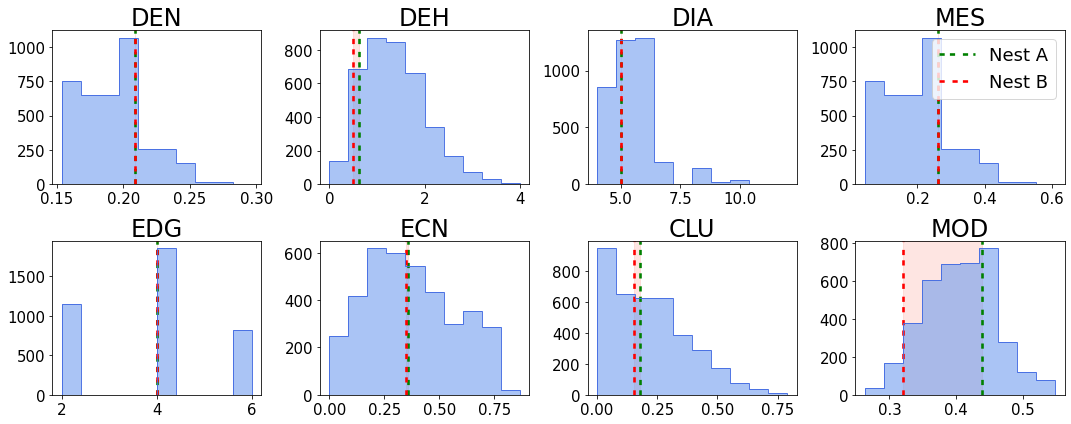

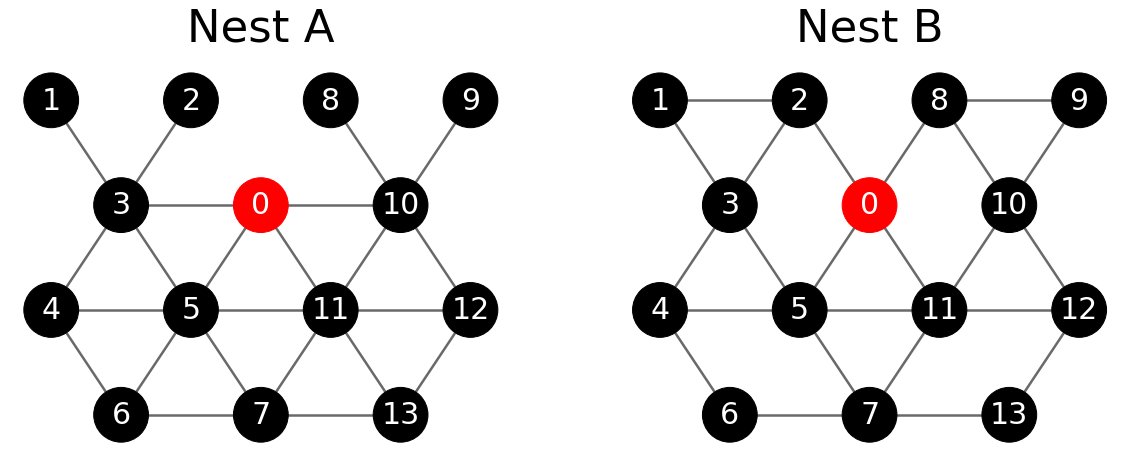

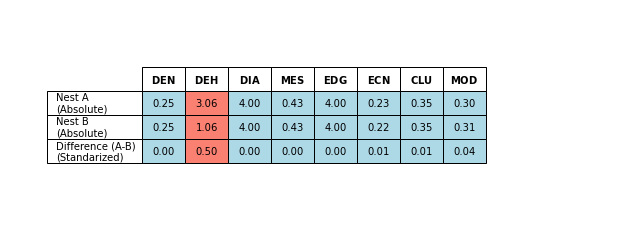

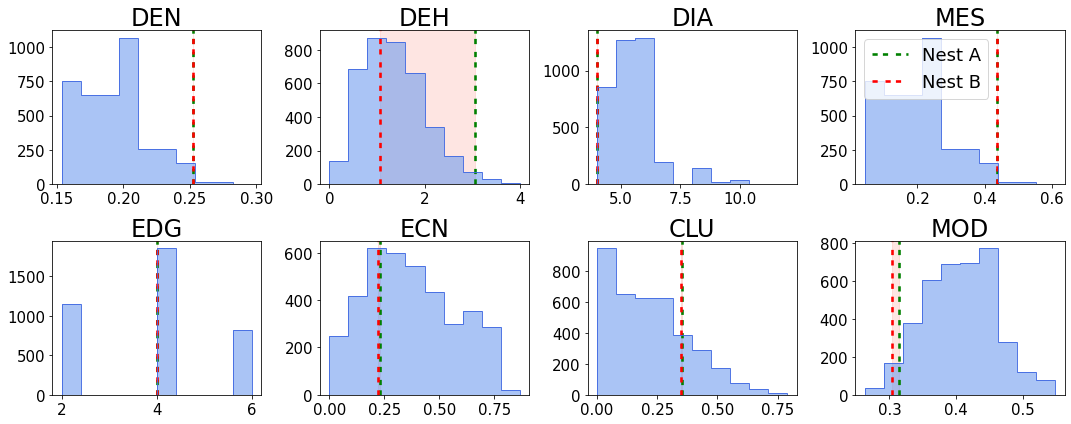

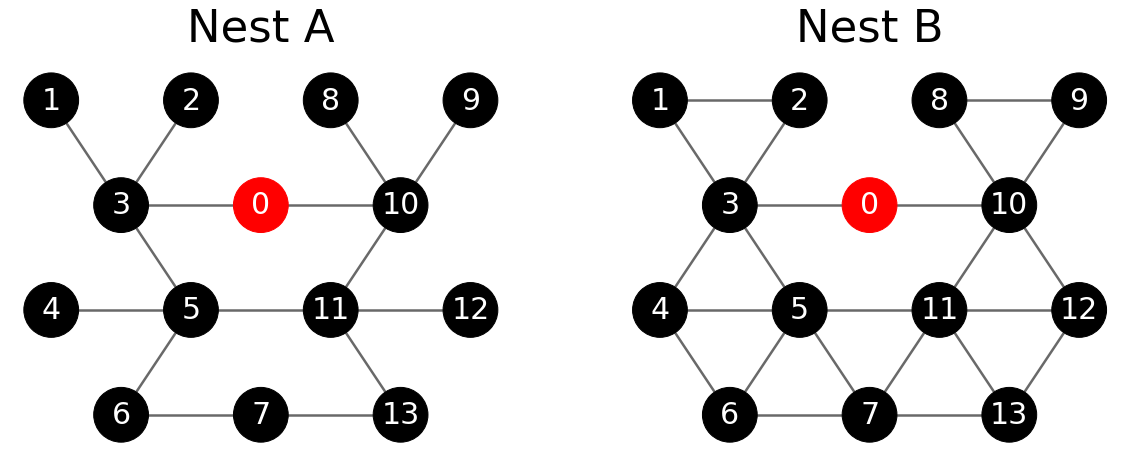

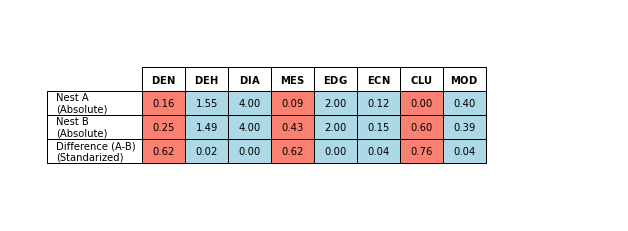

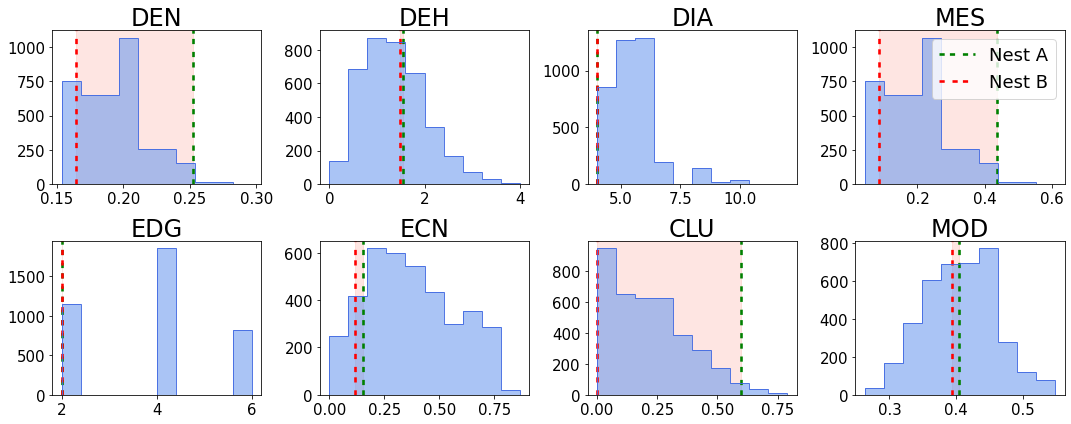

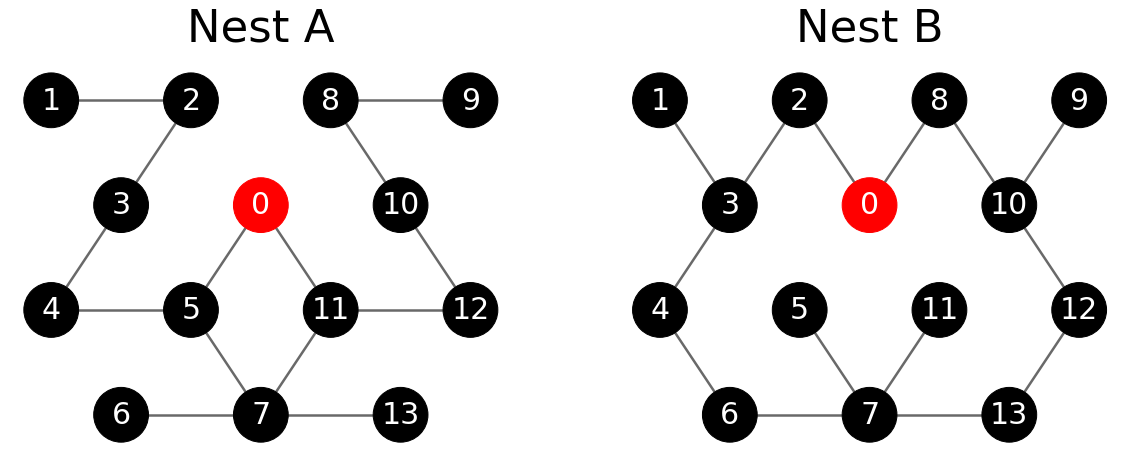

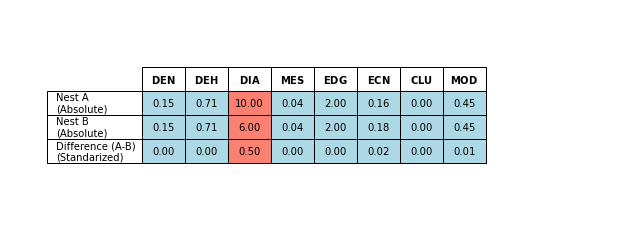

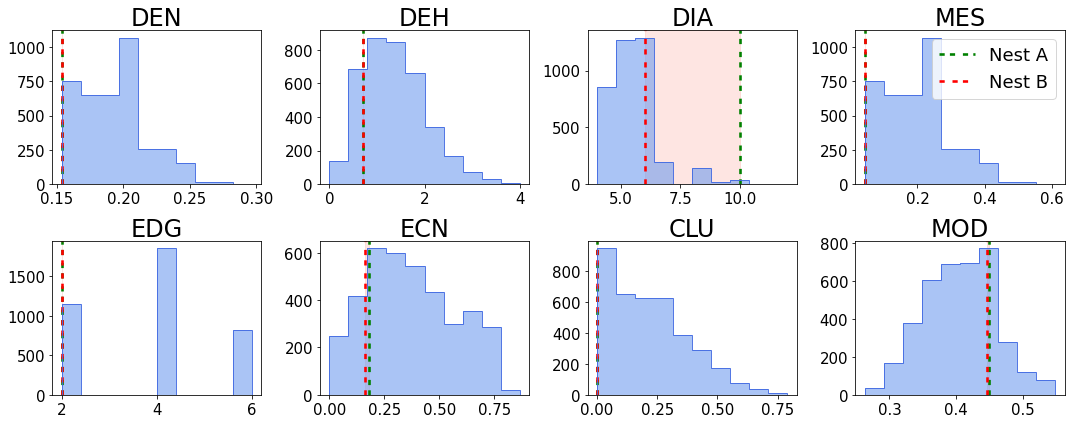

In [10]:
# Main script to calculate optimal nest pairs and accompanying plots

# Similarity treshold (5%)
tresh = 0.05

# Precision digits
dgt = 4

# Load property comparison dataframe
global ddf_diff_P
ddf_diff_P = dd.read_csv(G6_list_name + '/df_diff_P_ja/df_diff_P_*.csv').drop('Unnamed: 0',axis=1).set_index('G6_pair')

# Define properties cluster of interest (See HCA analysis)
global prop_clusters
prop_clusters = {
    0: ['modularity'],
    1: ['degree_heterogeneity'],
    2: ['density', 'meshedness', 'clustering'],
    3: ['diameter']}

# Loop through all the property clusters
for cluster in range(4):
    
    # Time record start
    start_time = time.time()


    # Read properties' names of cluster
    c = prop_clusters[cluster] 
    
    # Compute optimal nest pairs (See MM for details)
    m_j = ddf_diff_P.loc[ddf_diff_P.drop(c, axis=1).max(axis=1) < tresh * 10 ** dgt, c].min(axis=1)
    M_j = ddf_diff_P.drop(c, axis=1).loc[ddf_diff_P.drop(c, axis=1).max(axis=1) < tresh * 10 ** dgt, :].max(axis=1)
    
    df_msk = m_j - M_j
    pairs = df_msk[df_msk==df_msk.max()].compute().reset_index()['G6_pair']

    # Save list of optimal pairs
    pairs.to_csv(G6_list_name +'/plots/Top_pair_' + str(cluster) + '.csv')

    # Plot optimal pair diagrams and comparison table 
    [d1, d2] = plot_pair(G6_list_name, pairs[0], c, pairs_num=len(pairs), 
                         save_name=G6_list_name +'/plots/'+ 'Top_pair_'+str(cluster))

    # Plot distrubutios of properties with values of the optimal pairs
    fig, axs = plt.subplots(2,4, figsize=(15, 6))                 
    ddf_P = dd.read_csv(G6_list_name + '/df_P_ja/df_P_*.csv').set_index('G6')
    
    for i, prop in enumerate(ddf_P.columns):     
        x1 = np.min([d1[prop],d2[prop]])
        x2 = np.max([d1[prop],d2[prop]]) 
        axs[i//4,i%4].axvline(x2,c='g', linestyle = '--', linewidth=2.6, dashes=[2,2,2,3])
        axs[i//4,i%4].axvline(x1,c='r', linestyle = '--', linewidth=2.6, dashes=[2,3,2,2])
        
        # Legend (only on top right panel)
        if i==3:
            axs[0,3].legend(['Nest A', 'Nest B'], fontsize =18) 
            
        axs[i//4,i%4].tick_params(axis='x', labelsize=15)
        axs[i//4,i%4].tick_params(axis='y', labelsize=15)
        axs[i//4,i%4].axvspan(x1, x2, alpha=0.2, color='salmon')
        axs[i//4,i%4].hist(ddf_P[prop],histtype='stepfilled', alpha=0.55, color='cornflowerblue')
        axs[i//4,i%4].hist(ddf_P[prop],histtype='step', alpha=0.9, color='royalblue')
        axs[i//4,i%4].set_title(ABR[prop], fontsize=24)

    plt.tight_layout()    
    fig.savefig(G6_list_name + '/plots/dist_plot_' + str(cluster), dpi=250)

    end_time = time.time()
    print('Execution time Top_pair = %.6f seconds' % (end_time - start_time))
